# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [References](#reference)

## Introduction <a name="introduction"></a>

Singapore,located off the southern edge of the Malay Peninsula, between Malaysia and Indonesia has the 2nd highest population density in the world [1]. It has a **population of 5.7 million** with a a **population density of 7,854/km2** [2].

The property scene in Singapore is classified according to its postal (districts). There are **28 postal districts** in total [3]. 

This project aims to look at the property cost in Signapore by district with most common venues. This can help a resident choose an optimum location to buy a propoerty or an investor/business owner to choose a location to set up business

These questions/problems will be addressed by creating a map which shows the resident property price by district with each district being clustered according to the venue density.

## Data <a name="data"></a>

The following data are obtained: 
* Private Property Transcation Data API (2017 to Mar-2020) by Urban Redevelopment Authority (URA) [4]
* Postal District Boundary by user lozy219 in GitHub. [5]
* FourSquare API to get the most common venues by district [6]

Notes: 
There was not an offical boundaries for Singapore by postal district available. The source used has been quality checked and found to be good to use.
Only private residental transcation data has been used in this analysis. 

## Methodology <a name="methodology"></a>

**Retrieving Data**
The main data is reterieved from URA API [4] which consist of private property transcations in the last 3 years. Data was downloaded in 4 batches in pandas and were merged. 

Boundary/Location data is retreived and stored directly into a panda's dataframe

**Data Cleaning and Wrangling**
The merged data only had price transacted. Price per square foot was then computedand appended as new column. The data was then saved as a csv so that the process need not be repeated again.Manipulate data to find last date transcated.  

**Explore Data**
- Transcations per year *Histogram*
- *Box Plot* shows that average psf increases by year as expected and rates can be as high as $5000 psf

For this project, the analysis will be simplied by using the average for all 3 years. 

**Foursquare**
Use locationd data and Foursquare to retrieve venues near/in a particular district.  

**Analysis**
The limit was designed to 100 venue and the radius 1 km. There are 249 uniques categories.
A plot of venues count vs district/neighborhood is as below. A total of 1633 venues were returned with ~8 districts hitting the max limit of 100. 

Cluster analysis K-means was conduted with 5 clusters and each cluster was analzyed. 


In [96]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geopandas as gpd

import seaborn as sns #visualization library

print('Libraries imported.')

Libraries imported.


In [10]:
#batch1
#token valid on 3 April 2020
headers = {
    'AccessKey': 'a84a1f27-530f-4521-af50-ca34e098561c',
    'Token': 'QdDx4afPW15Y3@52YtbcW-5u1DA7Yj3W-AM1Wc082Y427FqF0--v6ndQRHa0b3Rg-v31M8a+h6qc8D035T-50Xg00ct1-f-Na5dn',
}

params = (
    ('service', 'PMI_Resi_Transaction'),
    ('batch', '1'),
)

response0 = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS', headers=headers, params=params).json()

In [11]:
#check retrieved data
#response0
response0['Result'][0]['transaction'][0]

{'area': '524.3',
 'contractDate': '0220',
 'district': '05',
 'floorRange': '-',
 'noOfUnits': '1',
 'price': '5500000',
 'propertyType': 'Semi-detached',
 'tenure': 'Freehold',
 'typeOfArea': 'Land',
 'typeOfSale': '3'}

In [18]:
#retrieve json to pandas
#https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas

df1 = json_normalize(data=response0['Result'], record_path='transaction', 
                            meta=['project', 'x', 'y'], errors = 'ignore')
df1.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,nettPrice,project,x,y
0,524.3,-,1,0220,3,5500000,Semi-detached,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,22726.561998910002,29491.915575680001
1,314,-,1,0618,3,4750000,Semi-detached,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,22726.561998910002,29491.915575680001
2,308,-,1,0918,3,5000000,Semi-detached,05,Land,Freehold,NaN,LANDED HOUSING DEVELOPMENT,22726.561998910002,29491.915575680001


In [19]:
#drop unecessary  columns
df1.drop(["floorRange", "noOfUnits","propertyType","typeOfArea","tenure","nettPrice", "x", "project", "y"], axis = 1, inplace = True)
df1['price'] = df1['price'].astype(int)
df1['area'] = df1['area'].astype(float)
print(df1.dtypes)
print(df1.shape)
df1.head()

area            float64
contractDate     object
typeOfSale       object
price             int64
district         object
dtype: object
(12201, 5)


,area,contractDate,typeOfSale,price,district
0,524.3,0220,3,5500000,05
1,314.0,0618,3,4750000,05
2,308.0,0918,3,5000000,05
3,348.0,0918,3,4400000,04
4,226.0,0118,3,3590000,04


In [20]:
#batch2
#token valid on 3 April 2020
headers = {
    'AccessKey': 'a84a1f27-530f-4521-af50-ca34e098561c',
    'Token': 'QdDx4afPW15Y3@52YtbcW-5u1DA7Yj3W-AM1Wc082Y427FqF0--v6ndQRHa0b3Rg-v31M8a+h6qc8D035T-50Xg00ct1-f-Na5dn',
}

params = (
    ('service', 'PMI_Resi_Transaction'),
    ('batch', '2'),
)

response1 = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS', headers=headers, params=params).json()

In [21]:
#retrieve json to pandas
#https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas

df2 = json_normalize(data=response1['Result'], record_path='transaction', 
                            meta=['project', 'x', 'y'], errors = 'ignore')
df2.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,nettPrice,project,x,y
0,106,06-10,1,1219,3,2200000,Apartment,10,Strata,Freehold,NaN,RESIDENTIAL APARTMENTS,27720.707451530001,32463.834072649999
1,140,01-05,1,0118,3,3080000,Apartment,10,Strata,Freehold,NaN,RESIDENTIAL APARTMENTS,27720.707451530001,32463.834072649999
2,197,06-10,1,0418,3,4200000,Apartment,10,Strata,Freehold,NaN,RESIDENTIAL APARTMENTS,27720.707451530001,32463.834072649999


In [22]:
#drop unecessary columns
df2.drop(["floorRange", "noOfUnits","propertyType","typeOfArea","tenure","nettPrice", "x", "project", "y"], axis = 1, inplace = True)
df2['price'] = df2['price'].astype(int)
df2['area'] = df2['area'].astype(float)
print(df2.dtypes)
print(df2.shape)
df2.head()

area            float64
contractDate     object
typeOfSale       object
price             int64
district         object
dtype: object
(18400, 5)


,area,contractDate,typeOfSale,price,district
0,106.0,1219,3,2200000,10
1,140.0,0118,3,3080000,10
2,197.0,0418,3,4200000,10
3,165.0,0718,3,1500000,08
4,157.0,0517,3,2580000,09


In [23]:
#batch3
#token valid on 3 April 2020
headers = {
    'AccessKey': 'a84a1f27-530f-4521-af50-ca34e098561c',
    'Token': 'QdDx4afPW15Y3@52YtbcW-5u1DA7Yj3W-AM1Wc082Y427FqF0--v6ndQRHa0b3Rg-v31M8a+h6qc8D035T-50Xg00ct1-f-Na5dn',
}

params = (
    ('service', 'PMI_Resi_Transaction'),
    ('batch', '3'),
)

response2 = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS', headers=headers, params=params).json()

In [24]:
#retrieve json to pandas
#https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas

df3 = json_normalize(data=response2['Result'], record_path='transaction', 
                            meta=['project', 'x', 'y'], errors = 'ignore')
df3.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,nettPrice,project,x,y
0,47,01-05,1,1219,3,810000,Condominium,15,Strata,Freehold,NaN,ELLIOT AT THE EAST COAST,38874.764492089998,32612.84399211
1,122,01-05,1,0419,3,1880000,Condominium,15,Strata,Freehold,NaN,ELLIOT AT THE EAST COAST,38874.764492089998,32612.84399211
2,161,01-05,1,0817,3,2050000,Condominium,15,Strata,Freehold,NaN,ELLIOT AT THE EAST COAST,38874.764492089998,32612.84399211


In [25]:
df3.drop(["floorRange", "noOfUnits","propertyType","typeOfArea","tenure","nettPrice", "x", "project", "y"], axis = 1, inplace = True)
df3['price'] = df3['price'].astype(int)
df3['area'] = df3['area'].astype(float)
print(df3.dtypes)
print(df3.shape)
df3.head()

area            float64
contractDate     object
typeOfSale       object
price             int64
district         object
dtype: object
(28826, 5)


,area,contractDate,typeOfSale,price,district
0,47.0,1219,3,810000,15
1,122.0,0419,3,1880000,15
2,161.0,0817,3,2050000,15
3,47.0,1218,3,800000,15
4,92.0,0919,3,1650000,15


In [26]:
#batch4
#token valid on 3 April 2020
headers = {
    'AccessKey': 'a84a1f27-530f-4521-af50-ca34e098561c',
    'Token': 'QdDx4afPW15Y3@52YtbcW-5u1DA7Yj3W-AM1Wc082Y427FqF0--v6ndQRHa0b3Rg-v31M8a+h6qc8D035T-50Xg00ct1-f-Na5dn',
}

params = (
    ('service', 'PMI_Resi_Transaction'),
    ('batch', '4'),
)

response3 = requests.get('https://www.ura.gov.sg/uraDataService/invokeUraDS', headers=headers, params=params).json()

In [27]:
#retrieve json to pandas
#https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas

df4 = json_normalize(data=response3['Result'], record_path='transaction', 
                            meta=['project', 'x', 'y'], errors = 'ignore')
df4.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,area,floorRange,noOfUnits,contractDate,typeOfSale,price,propertyType,district,typeOfArea,tenure,nettPrice,project,x,y
0,171,06-10,1,0819,3,1320000,Executive Condominium,22,Strata,99 yrs lease commencing from 1996,NaN,WESTMERE,17172.1153271,35522.173741630002
1,112,16-20,1,0819,3,1020000,Executive Condominium,22,Strata,99 yrs lease commencing from 1996,NaN,WESTMERE,17172.1153271,35522.173741630002
2,116,11-15,1,1019,3,1023000,Executive Condominium,22,Strata,99 yrs lease commencing from 1996,NaN,WESTMERE,17172.1153271,35522.173741630002


In [28]:
# drop unecessary columns
df4.drop(["floorRange", "noOfUnits","propertyType","typeOfArea","tenure","nettPrice", "x", "project", "y"], axis = 1, inplace = True)
df4['price'] = df4['price'].astype(int)
df4['area'] = df4['area'].astype(float)
print(df4.dtypes)
print(df4.shape)
df4.head()

area            float64
contractDate     object
typeOfSale       object
price             int64
district         object
dtype: object
(11778, 5)


,area,contractDate,typeOfSale,price,district
0,171.0,0819,3,1320000,22
1,112.0,0819,3,1020000,22
2,116.0,1019,3,1023000,22
3,116.0,0719,3,1000000,22
4,102.0,0519,3,918000,22


In [29]:
#merge all 4 dataframes to 1
df_final = pd.concat([df1, df2,df3,df4], ignore_index=True)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df_final.shape)
df_final.tail()

(12201, 5)
(18400, 5)
(28826, 5)
(11778, 5)
(71205, 5)


,area,contractDate,typeOfSale,price,district
71200,70.0,0617,1,1050200,27
71201,72.0,1017,1,1076300,27
71202,95.0,1119,2,1508000,27
71203,215.0,0819,3,1100000,27
71204,268.2,1017,3,2480000,27


In [30]:
#calculate psf from price and area
df_final['psf'] = df_final.apply(lambda row: (row.price)/(row.area*3.28*3.28), axis = 1)
df_final.head()

,area,contractDate,typeOfSale,price,district,psf
0,524.3,0220,3,5500000,05,975.068540
1,314.0,0618,3,4750000,05,1406.100213
2,308.0,0918,3,5000000,05,1508.938711
3,348.0,0918,3,4400000,04,1175.237783
4,226.0,0118,3,3590000,04,1476.516559


In [31]:
len(df_final['district'].unique().tolist())
#Lim chu kang tengah no data

27

In [32]:
#find mean psf per district
df_final.groupby('district', as_index=False)['psf'].mean()

,district,psf
0,01,2213.388663
1,02,2245.754355
2,03,1813.289305
3,04,1562.743584
4,05,1391.181559
5,06,1646.795763
6,07,2354.956614
7,08,1405.048165
8,09,2262.586420
9,10,2038.802731


In [33]:
#save data to csv file so that it wnt be necessary to import again
df_final.to_csv('housingprice_psf_mean_2017-20.csv')

In [ ]:
df_final['contractDate'] = df_final['contractDate'] .astype(str)

In [41]:
#manipulate dataframe to find last date transcated
last df = df_final[~df_final.contractDate.str.contains("17")]
df = df[~df.contractDate.str.contains("18")]
df = df[~df.contractDate.str.contains("19")]

print(df_final.shape)
print(df.shape)

df.sort_values(by=['contractDate'], inplace=True)
df.tail()

(71205, 6)
(4495, 6)


,area,contractDate,typeOfSale,price,district,psf
51639,478.0,0320,3,2381000,19,463.003007
51619,55.0,0320,3,720000,19,1216.808177
19609,100.0,0320,3,2100000,10,1951.963117
51853,163.0,0320,3,2030000,21,1157.605939
71049,80.0,0320,2,1300000,27,1510.447650


In [48]:
#remove data in contract year column such that only year is left behind
df_final['contractDate'] = df_final.contractDate.str[-2:]
df_final.head()

,area,contractDate,typeOfSale,price,district,psf
0,524.3,20,3,5500000,05,975.068540
1,314.0,18,3,4750000,05,1406.100213
2,308.0,18,3,5000000,05,1508.938711
3,348.0,18,3,4400000,04,1175.237783
4,226.0,18,3,3590000,04,1476.516559


Text(0.5,1,'Property Transcations in Singapore (Till Mar 2020)')

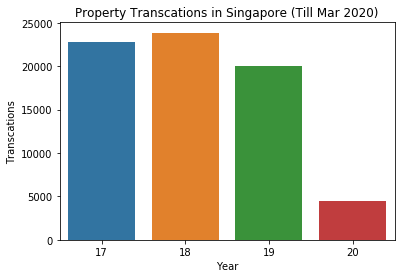

In [49]:
#plot data showing frequency transcation per year

p = sns.countplot(data=df_final, x = 'contractDate')
plt.xlabel('Year')
plt.ylabel('Transcations')
plt.title('Property Transcations in Singapore (Till Mar 2020)')

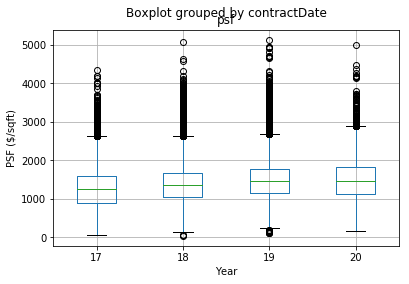

In [56]:
#box plot showing psf per year
box = df_final.boxplot(by="contractDate", column="psf")
plt.xlabel('Year')
plt.ylabel('PSF ($/sqft)')
#plt.title('PSF distribution per year')
box

In [59]:
#retrieve data for stats
df_box = df_final.drop('area', 1)
df_box = df_box.drop('typeOfSale',1)
df_box = df_box.drop('price',1)
df_box = df_box.drop('district',1)
df_box.shape
df_box.head()

df_box.describe()
df_box.groupby('contractDate').describe().unstack(1)

            contractDate
psf  count  17              22824.000000
            18              23849.000000
            19              20037.000000
            20               4495.000000
     mean   17               1302.025930
            18               1415.616445
            19               1537.700873
            20               1560.739324
     std    17                477.191911
            18                510.784049
            19                567.380886
            20                583.762289
     min    17                 58.680950
            18                 32.990926
            19                 99.606578
            20                164.487914
     25%    17                898.762501
            18               1041.574375
            19               1154.841094
            20               1120.057933
     50%    17               1247.228381
            18               1356.181953
            19               1457.447479
            20               145

In [63]:
address = 'Singapore, S'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.2450947, 103.8341488.


In [64]:
#Foursquare data
CLIENT_ID = 'WZYHPIOVUBN43NTSTXNFCCLI5LEYFSJXFV2WVJYB4M0DBQTO' # your Foursquare ID
CLIENT_SECRET = 'FS0BYDCWHTTXT1XQORXAAWFU0OWNSD03YVHBAQSAP0CHH4YY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WZYHPIOVUBN43NTSTXNFCCLI5LEYFSJXFV2WVJYB4M0DBQTO
CLIENT_SECRET:FS0BYDCWHTTXT1XQORXAAWFU0OWNSD03YVHBAQSAP0CHH4YY


In [199]:
#read shape file
sg_geo = gpd.read_file('district.json')
print(sg_geo.dtypes)
print(sg_geo.shape)
sg_geo

id             object
name           object
latitude      float64
longitude     float64
geometry     geometry
dtype: object
(28, 5)


,id,name,latitude,longitude,geometry
0,1,City - Marina Area,1.281632,103.857248,"MULTIPOLYGON (((103.86557 1.30013, 103.86561 1..."
1,10,Central: Tanglin,1.313139,103.806978,"MULTIPOLYGON (((103.83883 1.31333, 103.83787 1..."
2,11,Central - Newton,1.333708,103.819433,"MULTIPOLYGON (((103.85335 1.31837, 103.85232 1..."
3,12,Central - Toa Payoh,1.327013,103.857367,"MULTIPOLYGON (((103.84173 1.33933, 103.84283 1..."
4,13,Central East,1.334289,103.874079,"MULTIPOLYGON (((103.87030 1.34293, 103.87186 1..."
5,14,Central East - Eunos,1.324518,103.899600,"MULTIPOLYGON (((103.88887 1.33318, 103.89015 1..."
6,15,East Coast - Katong,1.303239,103.899318,"MULTIPOLYGON (((103.93370 1.31312, 103.93447 1..."
7,16,Upper East Coast,1.325951,103.946807,"MULTIPOLYGON (((103.91969 1.32124, 103.91945 1..."
8,2,City - CBD,1.272167,103.842780,"MULTIPOLYGON (((103.85294 1.27372, 103.85162 1..."
9,17,Far East - Changi,1.348583,103.998237,"MULTIPOLYGON (((103.96750 1.31538, 103.96711 1..."


In [65]:
neighborhood_latitude = sg_geo.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = sg_geo.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = sg_geo.loc[0, 'name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of City - Marina Area are 1.2816318469, 103.857247857.


In [245]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=WZYHPIOVUBN43NTSTXNFCCLI5LEYFSJXFV2WVJYB4M0DBQTO&client_secret=FS0BYDCWHTTXT1XQORXAAWFU0OWNSD03YVHBAQSAP0CHH4YY&v=20180605&ll=1.2816318469,103.857247857&radius=1000&limit=100'

In [246]:
results = requests.get(url).json()
#results

In [247]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [248]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Marina Bay Waterfront Promenade,Waterfront,1.281125,103.855556
1,New Creation Church (MBS),Church,1.282423,103.858840
2,Marina Bay Sands,Resort,1.283190,103.859124
3,Marina Bay Sands Boardwalk,Waterfront,1.284048,103.858491
4,Marina Bay Sands Hotel,Hotel,1.282932,103.860369


In [249]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [250]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [251]:
sg_venues = getNearbyVenues(names=sg_geo['Neighborhood'],
                                   latitudes=sg_geo['latitude'],
                                   longitudes=sg_geo['longitude']
                                  )

City - Marina Area
Central: Tanglin
Central - Newton
Central - Toa Payoh
Central East
Central East - Eunos
East Coast - Katong
Upper East Coast
City - CBD
Far East - Changi
Far East - Tampines
North East - Hougang
Central North - AMK
Central West
Far North West
Far North
Far West - Jurong
North West
Central - Little India
North
Far North - Yishun
North East - Seletar
Central South
South - Keppel
South West
City - City Hall
City - Beach Road 
Central - Orchard


In [252]:
print(sg_venues.shape)
sg_venues.head()

(1633, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,City - Marina Area,1.281632,103.857248,Marina Bay Waterfront Promenade,1.281125,103.855556,Waterfront
1,City - Marina Area,1.281632,103.857248,New Creation Church (MBS),1.282423,103.858840,Church
2,City - Marina Area,1.281632,103.857248,Marina Bay Sands,1.283190,103.859124,Resort
3,City - Marina Area,1.281632,103.857248,Marina Bay Sands Boardwalk,1.284048,103.858491,Waterfront
4,City - Marina Area,1.281632,103.857248,Marina Bay Sands Hotel,1.282932,103.860369,Hotel


In [253]:
sg_plot = sg_venues.groupby('Neighborhood').count()
print(sg_plot.dtypes)
sg_plot

Neighborhood Latitude     int64
Neighborhood Longitude    int64
Venue                     int64
Venue Latitude            int64
Venue Longitude           int64
Venue Category            int64
dtype: object


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Central - Little India,100,100,100,100,100,100
Central - Newton,9,9,9,9,9,9
Central - Orchard,100,100,100,100,100,100
Central - Toa Payoh,67,67,67,67,67,67
Central East,40,40,40,40,40,40
Central East - Eunos,79,79,79,79,79,79
Central North - AMK,36,36,36,36,36,36
Central South,69,69,69,69,69,69
Central West,80,80,80,80,80,80


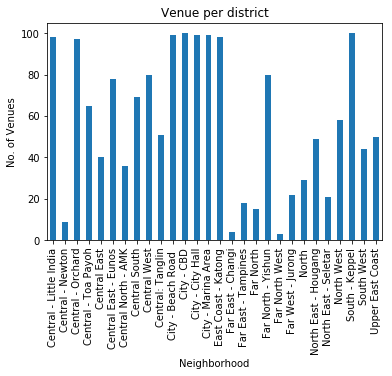

In [256]:
#plot data showing frequency transcation per year
sg_venues.groupby('Neighborhood')['Venue'].nunique().plot(kind='bar')

plt.ylabel('No. of Venues')
plt.title('Venue per district')

plt.show()

In [257]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 249 uniques categories.


In [258]:
sg_venues.groupby('Venue Category')['Venue'].count().sort_values(ascending=False)[:20]

Venue Category
Chinese Restaurant               94
Coffee Shop                      85
Food Court                       72
Café                             61
Hotel                            51
Indian Restaurant                50
Asian Restaurant                 45
Japanese Restaurant              38
Shopping Mall                    32
Bakery                           30
Bus Station                      27
Noodle House                     27
Fast Food Restaurant             26
Seafood Restaurant               25
Italian Restaurant               23
Restaurant                       23
Supermarket                      22
Park                             19
Dessert Shop                     19
Vegetarian / Vegan Restaurant    18
Name: Venue, dtype: int64

In [259]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bay,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Campground,Canal,Casino,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,College Gym,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,RV Park,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,City - Marina Area,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [260]:
sg_onehot.shape

(1633, 249)

In [261]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bay,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Campground,Canal,Casino,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,College Gym,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,RV Park,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Central - Little India,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.020000,0.00,0.00,0.020000,0.00,0.020000,0.010000,0.000000,0.00,0.01,0.000000,0.00,0.0000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.080000,0.00,0.000000,0.00,0.000000,0.080000,0.00,0.00,0.01,0.010000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000

In [262]:
sg_grouped.shape

(28, 249)

In [263]:
sg_grouped_1 = sg_grouped.drop(['Neighborhood'], axis = 1)
sg_grouped_1

,Yoga Studio,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bay,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Campground,Canal,Casino,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,College Gym,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Drugstore,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Fujian Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General College & University,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peking Duck Restaurant,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,RV Park,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Tourist Information Center,Toy / Game Store,Trail,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.020000,0.00,0.00,0.020000,0.00,0.020000,0.010000,0.000000,0.00,0.01,0.000000,0.00,0.0000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.080000,0.00,0.000000,0.00,0.000000,0.080000,0.00,0.00,0.01,0.010000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.000000,0.02000

In [264]:
num_top_venues = 5

for hood in sg_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sg_grouped[sg_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central - Little India----
                venue  freq
0   Indian Restaurant  0.20
1                Café  0.08
2  Chinese Restaurant  0.08
3              Hostel  0.04
4               Hotel  0.04


----Central - Newton----
                  venue  freq
0   Japanese Restaurant  0.22
1                 Trail  0.22
2  Other Great Outdoors  0.11
3                 Hotel  0.11
4                  Café  0.11


----Central - Orchard----
                 venue  freq
0                Hotel  0.07
1        Shopping Mall  0.07
2       Clothing Store  0.06
3  Japanese Restaurant  0.05
4      Bubble Tea Shop  0.04


----Central - Toa Payoh----
                  venue  freq
0    Chinese Restaurant  0.19
1      Asian Restaurant  0.07
2          Dessert Shop  0.07
3  Fast Food Restaurant  0.06
4          Noodle House  0.06


----Central East----
                venue  freq
0   Convenience Store  0.10
1  Chinese Restaurant  0.10
2          Food Court  0.10
3         Coffee Shop  0.08
4                Ca

In [265]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [266]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central - Little India,Indian Restaurant,Café,Chinese Restaurant,Hostel,Vegetarian / Vegan Restaurant,Hotel,Food Court,Restaurant,Soup Place,Asian Restaurant
1,Central - Newton,Japanese Restaurant,Trail,Modern European Restaurant,Other Great Outdoors,Park,Café,Hotel,Food,Flower Shop,Food & Drink Shop
2,Central - Orchard,Shopping Mall,Hotel,Clothing Store,Japanese Restaurant,Bubble Tea Shop,Boutique,Sushi Restaurant,Chinese Restaurant,Yoga Studio,Department Store
3,Central - Toa Payoh,Chinese Restaurant,Dessert Shop,Asian Restaurant,Noodle House,Fast Food Restaurant,Seafood Restaurant,Hotel,Coffee Shop,Indian Restaurant,Food Court
4,Central East,Convenience Store,Food Court,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Fast Food Restaurant,Bus Stop,Noodle House,Residential Building (Apartment / Condo)


In [267]:
# set number of clusters
kclusters = 5

sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 4, 0, 3, 3, 3, 3, 3, 3, 0], dtype=int32)

In [268]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central - Little India,Indian Restaurant,Café,Chinese Restaurant,Hostel,Vegetarian / Vegan Restaurant,Hotel,Food Court,Restaurant,Soup Place,Asian Restaurant
1,Central - Newton,Japanese Restaurant,Trail,Modern European Restaurant,Other Great Outdoors,Park,Café,Hotel,Food,Flower Shop,Food & Drink Shop
2,Central - Orchard,Shopping Mall,Hotel,Clothing Store,Japanese Restaurant,Bubble Tea Shop,Boutique,Sushi Restaurant,Chinese Restaurant,Yoga Studio,Department Store
3,Central - Toa Payoh,Chinese Restaurant,Dessert Shop,Asian Restaurant,Noodle House,Fast Food Restaurant,Seafood Restaurant,Hotel,Coffee Shop,Indian Restaurant,Food Court
4,Central East,Convenience Store,Food Court,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Fast Food Restaurant,Bus Stop,Noodle House,Residential Building (Apartment / Condo)


In [269]:
sg_geo = sg_geo.rename(columns={"name": "Neighborhood"})
sg_geo.head()

,id,Neighborhood,latitude,longitude,geometry
0,1,City - Marina Area,1.281632,103.857248,"MULTIPOLYGON (((103.86557 1.30013, 103.86561 1..."
1,10,Central: Tanglin,1.313139,103.806978,"MULTIPOLYGON (((103.83883 1.31333, 103.83787 1..."
2,11,Central - Newton,1.333708,103.819433,"MULTIPOLYGON (((103.85335 1.31837, 103.85232 1..."
3,12,Central - Toa Payoh,1.327013,103.857367,"MULTIPOLYGON (((103.84173 1.33933, 103.84283 1..."
4,13,Central East,1.334289,103.874079,"MULTIPOLYGON (((103.87030 1.34293, 103.87186 1..."


In [270]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = sg_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
                                 
print(sg_merged.dtypes)
sg_merged.head() # check the last columns!

id                          object
Neighborhood                object
latitude                   float64
longitude                  float64
geometry                  geometry
Cluster Labels               int32
1st Most Common Venue       object
2nd Most Common Venue       object
3rd Most Common Venue       object
4th Most Common Venue       object
5th Most Common Venue       object
6th Most Common Venue       object
7th Most Common Venue       object
8th Most Common Venue       object
9th Most Common Venue       object
10th Most Common Venue      object
dtype: object


,id,Neighborhood,latitude,longitude,geometry,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,City - Marina Area,1.281632,103.857248,"MULTIPOLYGON (((103.86557 1.30013, 103.86561 1...",0,Hotel,Italian Restaurant,Japanese Restaurant,Waterfront,Coffee Shop,Plaza,Bridge,Salad Place,Tea Room,Harbor / Marina
1,10,Central: Tanglin,1.313139,103.806978,"MULTIPOLYGON (((103.83883 1.31333, 103.83787 1...",0,Chinese Restaurant,Bus Station,Garden,Lounge,Wine Bar,Furniture / Home Store,Indian Restaurant,Modern European Restaurant,Café,Bar
2,11,Central - Newton,1.333708,103.819433,"MULTIPOLYGON (((103.85335 1.31837, 103.85232 1...",4,Japanese Restaurant,Trail,Modern European Restaurant,Other Great Outdoors,Park,Café,Hotel,Food,Flower Shop,Food & Drink Shop
3,12,Central - Toa Payoh,1.327013,103.857367,"MULTIPOLYGON (((103.84173 1.33933, 103.84283 1...",3,Chinese Restaurant,Dessert Shop,Asian Restaurant,Noodle House,Fast Food Restaurant,Seafood Restaurant,Hotel,Coffee Shop,Indian Restaurant,Food Court
4,13,Central East,1.334289,103.874079,"MULTIPOLYGON (((103.87030 1.34293, 103.87186 1...",3,Convenience Store,Food Court,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Fast Food Restaurant,Bus Stop,Noodle House,Residential Building (Apartment / Condo)


In [292]:
df_price2 = df_final.groupby('district', as_index=False)['psf'].mean()
print(df_price2.shape)
print(df_price2.dtypes)
df_price2

(27, 2)
district     object
psf         float64
dtype: object


,district,psf
0,01,2213.388663
1,02,2245.754355
2,03,1813.289305
3,04,1562.743584
4,05,1391.181559
5,06,1646.795763
6,07,2354.956614
7,08,1405.048165
8,09,2262.586420
9,10,2038.802731


In [294]:
#df_price2 = df_price2.append({'district' : 24 , 'psf' : 0}, ignore_index=True)
print(df_price2.shape)

df_price2['district'] = df_price2['district'] .astype(int)
df_price2.dtypes

(28, 2)


district      int64
psf         float64
dtype: object

In [295]:
sg_geo.shape
sg_geo['id'] = sg_geo['id'].astype(int)
sg_geo.dtypes

id                 int64
Neighborhood      object
latitude         float64
longitude        float64
geometry        geometry
dtype: object

In [296]:
for_plotting = sg_geo.merge(df_price2, left_on = 'id', right_on = 'district')
print(for_plotting.shape)
print(for_plotting.dtypes)
for_plotting

(28, 7)
id                 int64
Neighborhood      object
latitude         float64
longitude        float64
geometry        geometry
district           int64
psf              float64
dtype: object


,id,Neighborhood,latitude,longitude,geometry,district,psf
0,1,City - Marina Area,1.281632,103.857248,"MULTIPOLYGON (((103.86557 1.30013, 103.86561 1...",1,2213.388663
1,10,Central: Tanglin,1.313139,103.806978,"MULTIPOLYGON (((103.83883 1.31333, 103.83787 1...",10,2038.802731
2,11,Central - Newton,1.333708,103.819433,"MULTIPOLYGON (((103.85335 1.31837, 103.85232 1...",11,1705.344527
3,12,Central - Toa Payoh,1.327013,103.857367,"MULTIPOLYGON (((103.84173 1.33933, 103.84283 1...",12,1430.762554
4,13,Central East,1.334289,103.874079,"MULTIPOLYGON (((103.87030 1.34293, 103.87186 1...",13,1565.484193
5,14,Central East - Eunos,1.324518,103.899600,"MULTIPOLYGON (((103.88887 1.33318, 103.89015 1...",14,1434.035185
6,15,East Coast - Katong,1.303239,103.899318,"MULTIPOLYGON (((103.93370 1.31312, 103.93447 1...",15,1510.298843
7,16,Upper East Coast,1.325951,103.946807,"MULTIPOLYGON (((103.91969 1.32124, 103.91945 1...",16,1103.046265
8,2,City - CBD,1.272167,103.842780,"MULTIPOLYGON (((103.85294 1.27372, 103.85162 1...",2,2245.754355
9,17,Far East - Changi,1.348583,103.998237,"MULTIPOLYGON (((103.96750 1.31538, 103.96711 1...",17,983.348575


In [298]:
threshold_scale = np.linspace(df_price2['psf'].min(),
                              df_price2['psf'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

# create map
map1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
map1.choropleth(
    geo_data= r'district.json',
    data=for_plotting,
    columns=['Neighborhood', 'psf'],
    key_on= 'feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Singapore mean PSF',
    reset=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['latitude'], sg_merged['longitude'], sg_merged['Neighborhood'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map1)

map1

In [301]:
sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,0,Hotel,Italian Restaurant,Japanese Restaurant,Waterfront,Coffee Shop,Plaza,Bridge,Salad Place,Tea Room,Harbor / Marina
1,10,0,Chinese Restaurant,Bus Station,Garden,Lounge,Wine Bar,Furniture / Home Store,Indian Restaurant,Modern European Restaurant,Café,Bar
6,15,0,Chinese Restaurant,Indian Restaurant,Café,Asian Restaurant,Japanese Restaurant,Hotel,Italian Restaurant,Noodle House,Coffee Shop,Multiplex
8,2,0,Japanese Restaurant,Coffee Shop,Italian Restaurant,Bakery,Hotel,Cocktail Bar,Ramen Restaurant,Gym / Fitness Center,Salad Place,Café
21,28,0,Airport,Airport Terminal,Café,Modern European Restaurant,Bus Stop,Restaurant,English Restaurant,Bistro,Halal Restaurant,Office
25,6,0,Hotel,Japanese Restaurant,Cocktail Bar,Coffee Shop,Lounge,French Restaurant,Bakery,Café,Concert Hall,History Museum
26,7,0,Hotel,Café,Bakery,Italian Restaurant,Japanese Restaurant,Coffee Shop,Thai Restaurant,Restaurant,Shopping Mall,Dessert Shop
27,9,0,Shopping Mall,Hotel,Clothing Store,Japanese Restaurant,Bubble Tea Shop,Boutique,Sushi Restaurant,Chinese Restaurant,Yoga Studio,Department Store


In [302]:
sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,17,1,Campground,Airport,Airport Terminal,Trail,Flea Market,Event Space,Exhibit,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [303]:
sg_merged.loc[sg_merged['Cluster Labels'] == 2, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,24,2,Outdoors & Recreation,Military Base,Hostel,Women's Store,Exhibit,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Food


In [304]:
sg_merged.loc[sg_merged['Cluster Labels'] == 3, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,12,3,Chinese Restaurant,Dessert Shop,Asian Restaurant,Noodle House,Fast Food Restaurant,Seafood Restaurant,Hotel,Coffee Shop,Indian Restaurant,Food Court
4,13,3,Convenience Store,Food Court,Chinese Restaurant,Coffee Shop,Café,Asian Restaurant,Fast Food Restaurant,Bus Stop,Noodle House,Residential Building (Apartment / Condo)
5,14,3,Food Court,Coffee Shop,Chinese Restaurant,Asian Restaurant,Restaurant,Ramen Restaurant,Shopping Mall,Noodle House,Bubble Tea Shop,Diner
7,16,3,Coffee Shop,Food Court,Noodle House,Asian Restaurant,Bus Line,Dessert Shop,Malay Restaurant,Bus Station,Seafood Restaurant,School
10,18,3,Coffee Shop,Gym,Park,Food Court,Bus Station,Restaurant,Café,Grocery Store,Gym Pool,Seafood Restaurant
11,19,3,Food Court,Fast Food Restaurant,Pharmacy,Supermarket,Metro Station,Coffee Shop,Café,Shopping Mall,Chinese Restaurant,Laundromat
12,20,3,Chinese Restaurant,Soup Place,Food Court,Indian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Park,Bus Station,Café,Supermarket
13,21,3,Trail,Chinese Restaurant,Korean Restaurant,Food Court,Rest Area,Asian Restaurant,Thai Restaurant,Shopping Mall,Supermarket,Indian Restaurant
15,25,3,Bus Station,Bus Line,Racetrack,Stadium,Food Court,Dessert Shop,Coffee Shop,Gaming Cafe,Lighthouse,Asian Restaurant
16,22,3,Coffee Shop,Stadium,Basketball Court,Gym / Fitness Center,Electronics Store,Bakery,Seafood Restaurant,Soccer Field,Bus Line,Bus Station


In [305]:
sg_merged.loc[sg_merged['Cluster Labels'] == 4, sg_merged.columns[[0] + list(range(5, sg_merged.shape[1]))]]

,id,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,11,4,Japanese Restaurant,Trail,Modern European Restaurant,Other Great Outdoors,Park,Café,Hotel,Food,Flower Shop,Food & Drink Shop


## Results and Discussion <a name="results"></a>

Cluster Label 0
Districts: 1,10,15,2,28,6,7,9
Most of these districts are at city centre where property prices are at the higher end. 
Common venues are a mix of hotels, restuarants and hotels. 

Cluster Label 1
District: 17
This cluster has a single district and this is where the major airport is located.

Cluster Label 2
District: 24
This cluster has a single district in the far north 
Most common venue is outdoor recreation, military bases and hostels. 

Cluster Label 3
Districts: 12,13,14,16,18,19,20,21,25,22,23,8,26,27,,3,4,5
Most of the districts are in this cluster which would indicate the residental areas 
Common/frequent venues here are coffee shops and food courts

Cluster Label 4
District: 11
This cluster has a single district and is interestingly unique with most common venues that has a mix of both outdoors and restaurants 



## Conclusion <a name="conclusion"></a>

This project only provides a simplistic view of the property prices in Singapore by district with most common venues. 

Much more can be done with the data provided by zooming into a yearly analysis, looking at more factors such as size and/or integrating public data information. 

Access to such open data used in this analysis is very useful for any new property buyer, investor or business owner.

*Datafied by KS*

## References <a name="reference"></a>

1. https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density
2. https://www.singstat.gov.sg/modules/infographics/population
3. https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm
4. https://www.ura.gov.sg/maps/api/
5. https://github.com/lozy219/angular-singapore-district-map/blob/master/src/district.json
6. https://developer.foursquare.com 
